**Adaptive MLaaS Composability Model**
---

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import ast
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths
csv_file_path = '/content/Combined_MLaaS_Clients.csv'
client_dirs = [
    '/content/drive/MyDrive/MLaaS Genarator Weights/',
    '/content/drive/MyDrive/MLaaS Genarator Weights/NIID/',
    '/content/drive/MyDrive/MLaaS Genarator Weights/NIID_2/'
]
global_model_paths = [
     '/content/drive/MyDrive/MLaaS Genarator Weights/CSV AND GLOBAL/global_round_3.json',
    '/content/drive/MyDrive/MLaaS Genarator Weights/NIID/Global_model/global_round_3.json',
    '/content/drive/MyDrive/MLaaS Genarator Weights/NIID_2/Global_model/global_round_3.json'
]

# Load the CSV file
df = pd.read_csv(csv_file_path)

# Step 1: Parse the 'Data_Distribution' from string to dictionary
df['Parsed_Distribution'] = df['Data_Distribution'].apply(ast.literal_eval)

# Step 2: Compute the global reference distribution
client_distributions = np.array([list(dist.values()) for dist in df['Parsed_Distribution']])
global_reference_distribution = np.mean(client_distributions, axis=0)

# Step 3: Define thresholds
THRESHOLD_DUM = 490
THRESHOLD_SUM = 1.5
THRESHOLD_HQS = 0.05
THRESHOLD_SRS = 0.7
ALPHA_SUM = 1

# Step 4: Define functions for existing measurements
def compute_dum(client_distribution):
    ed = np.sqrt(np.sum((np.array(list(client_distribution.values())) - global_reference_distribution) ** 2))
    return 1 if ed < THRESHOLD_DUM else 0

def compute_sum(response_time, avg_response_time):
    value = (response_time / avg_response_time) ** ALPHA_SUM
    return 1 if value < THRESHOLD_SUM else 0

def compute_hqs(quality_factor, avg_quality_factor):
    similarity = np.abs(quality_factor - avg_quality_factor)
    return 1 if similarity <= THRESHOLD_HQS else 0

def compute_srs(reliability_score):
    return 1 if reliability_score >= THRESHOLD_SRS else 0

# Flatten model weights for MUM calculation
def flatten_weights(weights_dict):
    flat_weights = []
    for key in weights_dict:
        layer_weights = np.array(weights_dict[key])
        flat_weights.extend(layer_weights.flatten())
    return np.array(flat_weights)

def calculate_mum(local_weights, global_weights):
    min_length = min(len(local_weights), len(global_weights))
    local_weights = local_weights[:min_length]
    global_weights = global_weights[:min_length]
    differences = np.abs((local_weights - global_weights) / global_weights)
    return np.mean(differences)

# Load global models
global_models = []
for path in global_model_paths:
    with open(path, 'r') as f:
        global_weights = json.load(f)
        global_models.append(flatten_weights(global_weights))

# Step 5: Calculate average response time and quality factor
avg_response_time = df['Computation_Time'].mean()
avg_quality_factor = df['Quality_Factor'].mean()

# Initialize a list for results
binary_vector = []

# Process each client in the directories
client_index = 0
for dir_index, client_dir in enumerate(client_dirs):
    for filename in sorted(os.listdir(client_dir)):
        if filename.endswith('.json'):
            client_file_path = os.path.join(client_dir, filename)
            with open(client_file_path, 'r') as client_file:
                local_weights = json.load(client_file)
                local_flat = flatten_weights(local_weights)
                mum_value = calculate_mum(local_flat, global_models[dir_index])

                # Get corresponding row from DataFrame
                row = df.iloc[client_index]
                dum_score = compute_dum(row['Parsed_Distribution'])
                sum_score = compute_sum(row['Computation_Time'], avg_response_time)
                hqs_score = compute_hqs(row['Quality_Factor'], avg_quality_factor)
                srs_score = compute_srs(row['Reliability_Score'])
                mum_score = 1 if mum_value < 0.3 else 0  # Threshold for MUM

                # Append scores
                client_vector = [dum_score, sum_score, hqs_score, srs_score, mum_score]
                binary_vector.append(client_vector)
                client_index += 1

# Convert to DataFrame and save
binary_vector_df = pd.DataFrame(binary_vector, columns=['DUM', 'SUM', 'HQS', 'SRS', 'MUM'])
binary_vector_df['Client'] = df['Client'].values
output_file = '/content/drive/MyDrive/MLaaS Genarator Weights/Final_Results_With_MUM.csv'
binary_vector_df.to_csv(output_file, index=False)

# Display the results
print("Final scores with MUM included:")
print(binary_vector_df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Final scores with MUM included:
     DUM  SUM  HQS  SRS  MUM     Client
0      1    1    1    1    1   client_1
1      1    1    1    1    1   client_2
2      1    1    1    1    1   client_3
3      1    1    1    1    1   client_4
4      1    1    1    1    1   client_5
..   ...  ...  ...  ...  ...        ...
175    1    1    0    0    1  client_16
176    1    1    1    0    1  client_17
177    1    1    1    0    1  client_18
178    1    1    1    0    1  client_19
179    1    1    1    0    1  client_20

[180 rows x 6 columns]


In [ ]:
binary_vector_df['MUM'].value_counts()

,count
MUM,
1,110
0,70


In [ ]:
import pandas as pd
import numpy as np
import ast

# Load the CSV file
file_path = '/content/Combined_MLaaS_Clients.csv'
df = pd.read_csv(file_path)

# Step 1: Parse the 'Data_Distribution' from string to dictionary
df['Parsed_Distribution'] = df['Data_Distribution'].apply(ast.literal_eval)

# Step 2: Compute the global reference distribution
client_distributions = np.array([list(dist.values()) for dist in df['Parsed_Distribution']])
global_reference_distribution = np.mean(client_distributions, axis=0)

# Step 3: Define thresholds
THRESHOLD_DUM = 405  # Adjust as needed
THRESHOLD_SUM = 1.5  # Example threshold for response time ratio
THRESHOLD_HQS = 0.05  # Allowable difference in quality factor
THRESHOLD_SRS = 0.7  # Minimum acceptable reliability score
ALPHA_SUM = 1  # Power parameter for SUM computation

# Step 4: Define functions for each measurement
def compute_dum(client_distribution):
    ed = np.sqrt(np.sum((np.array(list(client_distribution.values())) - global_reference_distribution) ** 2))
    return 1 if ed < THRESHOLD_DUM else 0

def compute_sum(response_time, avg_response_time):
    value = (response_time / avg_response_time) ** ALPHA_SUM
    return 1 if value < THRESHOLD_SUM else 0

def compute_hqs(quality_factor, avg_quality_factor):
    similarity = np.abs(quality_factor - avg_quality_factor)
    return 1 if similarity <= THRESHOLD_HQS else 0

def compute_srs(reliability_score):
    return 1 if reliability_score >= THRESHOLD_SRS else 0

# Step 5: Calculate average response time and quality factor for comparison
avg_response_time = df['Computation_Time'].mean()
avg_quality_factor = df['Quality_Factor'].mean()

# Step 6: Apply functions and generate the binary vector
binary_vector = []

for index, row in df.iterrows():
    dum_score = compute_dum(row['Parsed_Distribution'])
    sum_score = compute_sum(row['Computation_Time'], avg_response_time)
    hqs_score = compute_hqs(row['Quality_Factor'], avg_quality_factor)
    srs_score = compute_srs(row['Reliability_Score'])

    # Combine all scores into a vector
    client_vector = [dum_score, sum_score, hqs_score, srs_score]
    binary_vector.append(client_vector)

# Convert to DataFrame for better visualization
binary_vector_df = pd.DataFrame(binary_vector, columns=['DUM', 'SUM', 'HQS', 'SRS'])
binary_vector_df['Client'] = df['Client'].values

# Save the results to a new CSV file
output_file = '/content/Adaptive_MLaaS_Composition.csv'
binary_vector_df.to_csv(output_file, index=False)

# Display the result
print("Binary vector scores for each client:")
print(binary_vector_df)


Binary vector scores for each client:
     DUM  SUM  HQS  SRS     Client
0      1    1    1    1   client_1
1      1    1    1    1   client_2
2      1    1    1    1   client_3
3      1    1    1    1   client_4
4      1    1    1    1   client_5
..   ...  ...  ...  ...        ...
175    0    1    0    0  client_16
176    0    1    1    0  client_17
177    0    1    1    0  client_18
178    0    1    1    0  client_19
179    0    1    1    0  client_20

[180 rows x 5 columns]


In [ ]:
binary_vector_df['DUM'].value_counts()

,count
DUM,
0,120
1,60


In [ ]:
binary_vector_df['SUM'].value_counts()

,count
SUM,
1,153
0,27


In [ ]:
binary_vector_df['HQS'].value_counts()

,count
HQS,
0,137
1,43


In [ ]:
binary_vector_df['SRS'].value_counts()

,count
SRS,
1,90
0,90


**Experiment setup**
---

In [28]:
# Re-import necessary libraries after state reset
import pandas as pd
import matplotlib.pyplot as plt
Combined = pd.read_csv('/content/Combined_MLaaS_Service.csv')
Combined

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Client,Round,Data_Distribution,Computation_Time,Quality_Factor,Reliability_Score,MLaaS_ID,model category,QualityCategory,Service_ID
0,0,1,1,client_2,1,"{0: 307, 1: 332, 2: 282, 3: 313, 4: 298, 5: 24...",1.536191,0.5383,0.733767,2,Minist16,0,1
1,1,19,19,client_20,1,"{0: 297, 1: 325, 2: 309, 3: 314, 4: 290, 5: 26...",1.480564,0.6062,0.748367,20,Minist16,0,2
2,2,25,25,client_6,2,"{0: 287, 1: 361, 2: 278, 3: 335, 4: 279, 5: 26...",1.425591,0.7786,0.715533,26,Minist16,0,3
3,3,29,29,client_10,2,"{0: 308, 1: 339, 2: 308, 3: 279, 4: 285, 5: 27...",2.424607,0.8028,0.742767,30,Minist16,0,4
4,4,30,30,client_11,2,"{0: 275, 1: 346, 2: 296, 3: 296, 4: 288, 5: 27...",2.072800,0.7983,0.740467,31,Minist16,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475,2475,1443,1443,client_4,9,"{0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 50, 6: ...",1.696836,0.7548,0.777390,364,HAR64,0,2476
2476,2476,415,415,client_16,2,"{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 10...",1.890466,0.7049,0.778200,236,HAR64,0,2477
2477,2477,1837,1837,client_18,18,"{0: 300, 1: 300, 2: 300, 3: 300, 4: 300, 5: 30...",8.042612,0.8362,0.799320,358,HAR64,0,2478
2478,2478,170,170,client_11,3,"{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 10...",0.724259,0.6458,0.492667,171,HAR64,0,2479


**Manual Adaptive Composition**
---

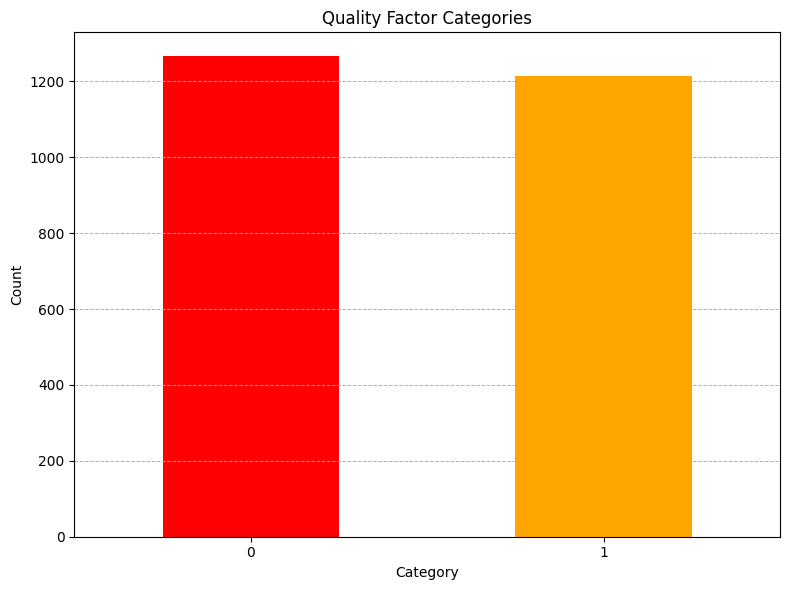

In [29]:
import pandas as pd
import matplotlib.pyplot as plt


# Categorize the QualityFactor values
def categorize_quality(factor):
    if factor < 0.80:
        return 0
    else:
        return 1

# Apply categorization
Combined['QualityCategory'] = Combined['Reliability_Score'].apply(categorize_quality)

# Count the occurrences of each category
category_counts = Combined['QualityCategory'].value_counts()

# Plotting the histogram
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color=['red', 'orange', 'green'])
plt.title('Quality Factor Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

In [30]:
AdaptiveMLaaS = pd.read_csv('/content/Adaptive_MLaaS_Composition.csv')
AdaptiveMLaaS

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,DUM,SUM,HQS,SRS,MUM,Client,model category,Composability_Score,Service_ID
0,0,1,1,1,1,1,1,1,client_2,Minist16,1,1
1,1,19,19,1,1,1,1,1,client_20,Minist16,1,2
2,2,25,25,1,1,0,1,1,client_6,Minist16,1,3
3,3,29,29,1,0,0,1,1,client_10,Minist16,0,4
4,4,30,30,1,1,0,1,1,client_11,Minist16,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2475,2475,1443,1443,1,1,0,0,0,client_6,HAR64,0,2476
2476,2476,415,415,1,1,0,1,0,client_17,HAR64,0,2477
2477,2477,1837,1837,1,1,1,0,0,client_7,HAR64,0,2478
2478,2478,170,170,1,1,0,0,1,client_11,HAR64,0,2479


In [31]:
AdaptiveMLaaS['model category'].value_counts()

,count
model category,
Minist64,532
FMinist32,387
FMinist16,307
HAR32,240
HAR16,239
HAR64,238
FMinist64,237
Minist32,172
Minist16,128


**Adaptive MlaaS Composition**
---

In [32]:
import pandas as pd
import numpy as np
# Assigning weights to each metric
weights = {
    'DUM': 0.7,
    'SUM': 0.7,
    'HQS': 0.6,
    'SRS': 0.9,
    'MUM': 0.9 # Assuming equal weights; you can adjust as needed
}
# Calculating the composability score
AdaptiveMLaaS['Composability_Score'] = (
    AdaptiveMLaaS['DUM'] * weights['DUM'] +
   AdaptiveMLaaS['SUM'] * weights['SUM'] +
    AdaptiveMLaaS['HQS'] * weights['HQS'] +
    AdaptiveMLaaS['SRS'] * weights['SRS'] +
    AdaptiveMLaaS['MUM'] * weights['MUM']
) / 5  # Division by 1 is not needed since weights sum to 1, but kept for clarity

# Ensure the score is between 0 and 1 (it should be already due to the weighting scheme)
AdaptiveMLaaS['Composability_Score'] = AdaptiveMLaaS['Composability_Score'].clip(0, 1)
AdaptiveMLaaS

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,DUM,SUM,HQS,SRS,MUM,Client,model category,Composability_Score,Service_ID
0,0,1,1,1,1,1,1,1,client_2,Minist16,0.76,1
1,1,19,19,1,1,1,1,1,client_20,Minist16,0.76,2
2,2,25,25,1,1,0,1,1,client_6,Minist16,0.64,3
3,3,29,29,1,0,0,1,1,client_10,Minist16,0.50,4
4,4,30,30,1,1,0,1,1,client_11,Minist16,0.64,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2475,2475,1443,1443,1,1,0,0,0,client_6,HAR64,0.28,2476
2476,2476,415,415,1,1,0,1,0,client_17,HAR64,0.46,2477
2477,2477,1837,1837,1,1,1,0,0,client_7,HAR64,0.40,2478
2478,2478,170,170,1,1,0,0,1,client_11,HAR64,0.46,2479


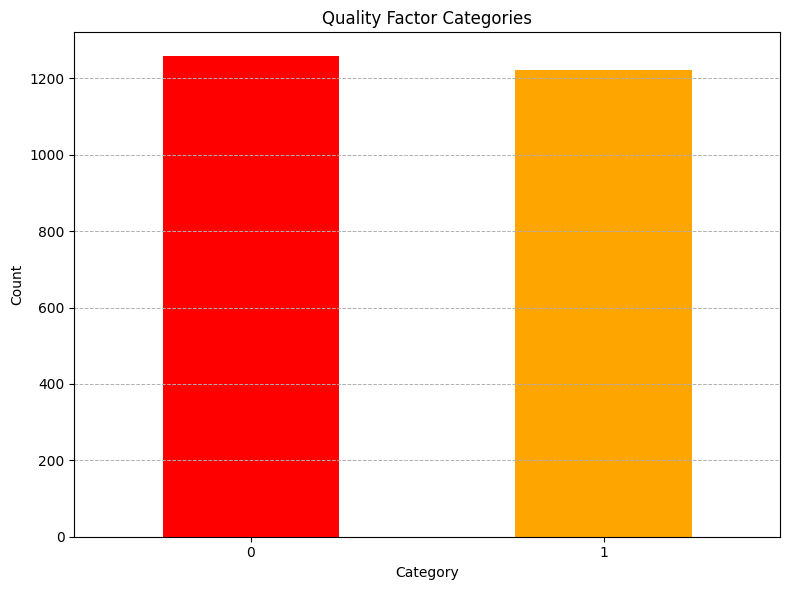

In [33]:
# Re-import necessary libraries after state reset
import pandas as pd
import matplotlib.pyplot as plt
# Categorize the QualityFactor values
def categorize_quality(factor):
    if factor < 0.55:
        return 0
    else:
        return 1
# Apply categorization
AdaptiveMLaaS['Composability_Score'] = AdaptiveMLaaS['Composability_Score'].apply(categorize_quality)
# Count the occurrences of each category
category_counts = AdaptiveMLaaS['Composability_Score'].value_counts()
# Plotting the histogram
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color=['red', 'orange', 'green'])
plt.title('Quality Factor Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

In [34]:
# Adding 'Service_ID' column to the existing AdaptiveMLS DataFrame
Combined['Service_ID'] = range(1, len(Combined) + 1)
AdaptiveMLaaS['Service_ID'] = range(1, len(AdaptiveMLaaS) + 1)

**Results**
---

In [35]:
import pandas as pd
Combined.to_csv("actual.csv")
AdaptiveMLaaS.to_csv("predicted.csv")
# Load the actual and predicted CSV files
actual_df = pd.read_csv('/content/actual.csv')
predicted_df = pd.read_csv('/content/predicted.csv')

# Merge both DataFrames using 'Service_ID' for accurate comparison
comparison_df = pd.merge(
    actual_df[['Service_ID', 'QualityCategory']],
    predicted_df[['Service_ID', 'Composability_Score']],
    on='Service_ID',
    how='inner'
)
# Initialize sets to categorize services
tp_services = set()
tn_services = set()
fp_services = set()
fn_services = set()

# Categorizing services based on true and predicted labels
for _, row in comparison_df.iterrows():
    service_id = row['Service_ID']
    true_label = row['QualityCategory']
    predicted_label = row['Composability_Score']

    if true_label == 1 and predicted_label == 1:
        tp_services.add(service_id)
    elif true_label == 0 and predicted_label == 0:
        tn_services.add(service_id)
    elif true_label == 0 and predicted_label == 1:
        fp_services.add(service_id)
    elif true_label == 1 and predicted_label == 0:
        fn_services.add(service_id)

# Convert sets to lists for better handling
tp_services = list(tp_services)
tn_services = list(tn_services)
fp_services = list(fp_services)
fn_services = list(fn_services)

# Display categorized service IDs
print(f"True Positives ({len(tp_services)} services):", tp_services)
print(f"True Negatives ({len(tn_services)} services):", tn_services)
print(f"False Positives ({len(fp_services)} services):", fp_services)
print(f"False Negatives ({len(fn_services)} services):", fn_services)


True Positives (1161 services): [2050, 2052, 2053, 2055, 2056, 2444, 2059, 2060, 2063, 2064, 2066, 2446, 2069, 2447, 2073, 2448, 2081, 2082, 2083, 2084, 2085, 2091, 2092, 2094, 2096, 2097, 2452, 2102, 2103, 2104, 2105, 2107, 2454, 2110, 2112, 2455, 2116, 2117, 2118, 2119, 2123, 2125, 2127, 2128, 2129, 2458, 2131, 2132, 2133, 2134, 2459, 2138, 2143, 2144, 2148, 2150, 2153, 2154, 2156, 2158, 2159, 2162, 2164, 2165, 2167, 2466, 2169, 2170, 2174, 2175, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 2227, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 2237, 196, 197, 198, 199, 200, 201, 2242, 2245, 204, 205, 206, 2246, 2248, 209, 210, 211, 212, 213, 214, 2255, 216, 217, 2261, 2262, 220, 221, 222, 223, 224, 225, 2265, 227, 228, 229, 2269, 2270, 2273, 2274, 2275, 22

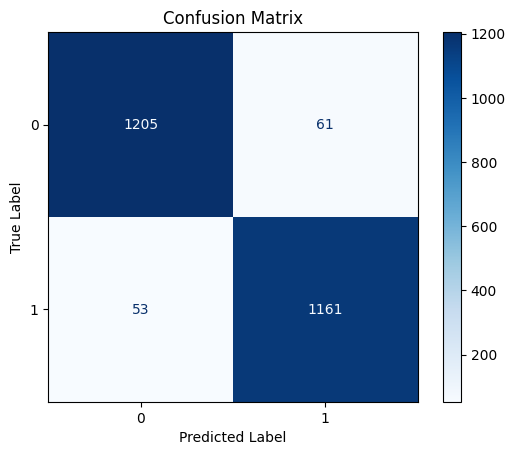

In [36]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Extract 'result' columns
true_labels =actual_df['QualityCategory'][:]
predicted_labels =predicted_df['Composability_Score'][:]

# Compute the confusion matrix
labels = [0,1]  # Define your categories
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [37]:
# Calculate Accuracy, Precision, Recall, and F1-Score
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, labels=labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, labels=labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, labels=labels, average='weighted')
# Display results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.95
Precision: 0.95
Recall: 0.95
F1-Score: 0.95


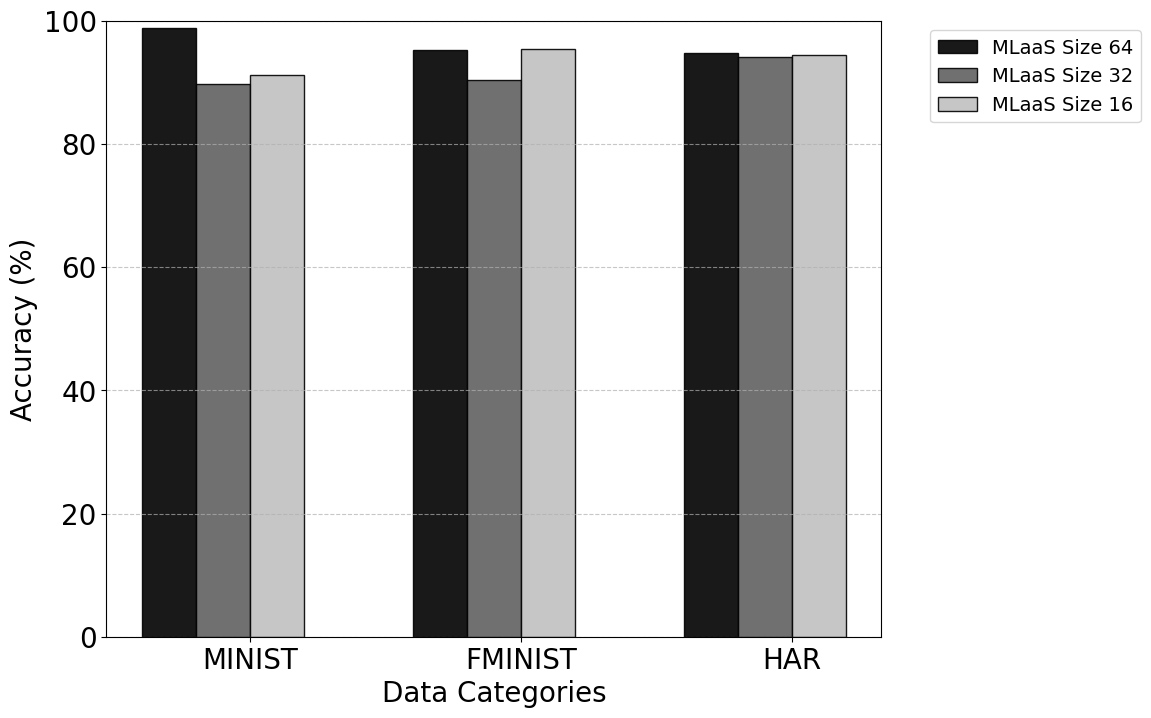

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the updated CSV files
actual_df = pd.read_csv("actual.csv")
predicted_df = pd.read_csv("predicted.csv")

# Merge DataFrames using 'Service_ID'
merged_df = pd.merge(
    actual_df[['Service_ID', 'model category', 'QualityCategory']],
    predicted_df[['Service_ID', 'Composability_Score']],
    on='Service_ID',
    how='inner'
)

# Define broader categories (Minist, FMinist, HAR) and their respective sizes
broader_categories = {
    "MINIST": ["Minist64", "Minist32", "Minist16"],
    "FMINIST": ["FMinist64", "FMinist32", "FMinist16"],
    "HAR": ["HAR64", "HAR32", "HAR16"]
}

# Define grayscale colors based on size
size_colors = {
    "64": "#000000",  # Black
    "32": "#606060",  # Dark Gray
    "16": "#C0C0C0"   # Light Gray
}

# Function to compute accuracy for each model
def compute_accuracy(df, model_list):
    accuracy_dict = {}
    for model in model_list:
        subset = df[df['model category'] == model]
        total = len(subset)
        correct = (subset['QualityCategory'] == subset['Composability_Score']).sum()
        accuracy_dict[model] = (correct / total) * 99 if total > 0 else 0
    return accuracy_dict

# Compute accuracy for each broader category
accuracy_data = {category: compute_accuracy(merged_df, broader_categories[category]) for category in broader_categories}

# Prepare data for plotting
x_labels = list(broader_categories.keys())  # ["MINIST", "FMINIST", "HAR"]
x = np.arange(len(x_labels))  # X positions
width = 0.2  # Width of bars

# Store legend handles
legend_handles = {}

# Plot the grouped bar chart
plt.figure(figsize=(10, 8))

for i, category in enumerate(x_labels):
    sub_models = broader_categories[category]  # Get sub-models for this category
    for j, sub_model in enumerate(sub_models):
        model_size = sub_model[-2:]  # Extract size (64, 32, 16) from model name
        accuracy_value = accuracy_data[category].get(sub_model, 0)

        # Get the color for the size
        color = size_colors.get(model_size, "#CCCCCC")  # Default to light gray if missing

        bar = plt.bar(x[i] + (j - len(sub_models) / 2) * width, accuracy_value, width,
                      label=f"MLaaS Size {model_size}" if model_size not in legend_handles else "",
                      color=color, edgecolor="black", alpha=0.9)

        # Add to legend only once
        if model_size not in legend_handles:
            legend_handles[model_size] = bar

# Labels and formatting
plt.xlabel("Data Categories", fontsize=20)
plt.ylabel("Accuracy (%)", fontsize=20)
plt.xticks(x, x_labels, rotation=0, ha="center", fontsize=18)  # Increase font size
plt.ylim(0, 100)  # Accuracy range (0-100%)

# Move legend outside the plot (Right Side)
plt.legend(title="", loc="upper left", fontsize=14, bbox_to_anchor=(1.05, 1))

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# Show the plot
plt.show()

In [43]:
actual_df.to_csv("/content/Combined_MLaaS_Service.csv")
predicted_df.to_csv("/content/Adaptive_MLaaS_Composition.csv")

In [ ]:
Combined.columns

Index(['Unnamed: 0', 'Client', 'Round', 'Data_Distribution',
       'Computation_Time', 'Quality_Factor', 'Reliability_Score', 'MLaaS_ID',
       'model category', 'QualityCategory', 'Service_ID'],
      dtype='object')

In [42]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the list of sample sizes
sample_sizes = [250, 500, 750, 1000, 1250, 1500, 1750, 2000]

# Initialize a list to store metrics
metrics_list = []

# Shuffle the entire dataset once and reset indices
shuffled_combined = Combined.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_adaptive = AdaptiveMLaaS.sample(frac=1, random_state=42).reset_index(drop=True)

# Loop through each sample size and calculate metrics using sequential sampling
for size in sample_sizes:
    # Extract true and predicted labels sequentially from shuffled datasets
    true_labels = shuffled_combined['QualityCategory'][:size]
    predicted_labels = shuffled_adaptive['Composability_Score'][:size]

    # Calculate Accuracy, Precision, Recall, and F1-Score with zero_division handling
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, labels=[0, 1], average='weighted', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, labels=[0, 1], average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, labels=[0, 1], average='weighted', zero_division=0)

    # Append the results to the list
    metrics_list.append({
        'Sample_Size': size,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    })

# Convert the list of dictionaries into a DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Display the final DataFrame with all metrics
print(metrics_df)

   Sample_Size  Accuracy  Precision    Recall  F1_Score
0          250  0.964000   0.965460  0.964000  0.963972
1          500  0.956000   0.956484  0.956000  0.955997
2          750  0.954667   0.954721  0.954667  0.954667
3         1000  0.953000   0.953090  0.953000  0.952998
4         1250  0.952800   0.952858  0.952800  0.952799
5         1500  0.951333   0.951374  0.951333  0.951333
6         1750  0.954857   0.954888  0.954857  0.954857
7         2000  0.954500   0.954514  0.954500  0.954501
